# Telecom churn (cell2cell)
#### Data source: https://www.kaggle.com/jpacse/datasets-for-churn-telecom
Teradata center for customer relationship management at Duke University

# Table of content
## 1. EDA
## 2. Churn prediction models
    2.1 Logistic regression
    2.2 Random forest
    2.3 Gradient tree boosting
    2.4 Light GBM
## 3. Final model
## 4. Summary

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model as lm, metrics, model_selection as ms, preprocessing, tree, ensemble
from sklearn.pipeline import Pipeline
from sklearn import linear_model as lm
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import lightgbm as lgb

%matplotlib inline

# 1. EDA

In [2]:
tele = pd.read_csv('cell2celltrain.csv')
tele.head(3)

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes


In [3]:
tele.shape

(51047, 58)

In [4]:
Churn = tele['Churn'].value_counts()
Churn

No     36336
Yes    14711
Name: Churn, dtype: int64

In [5]:
# Replace yes, no with 1, 0
tele['Churn'] = (tele['Churn'] != 'No').astype(int)
tele.shape

(51047, 58)

In [6]:
tele.isnull().sum()

CustomerID                     0
Churn                          0
MonthlyRevenue               156
MonthlyMinutes               156
TotalRecurringCharge         156
DirectorAssistedCalls        156
OverageMinutes               156
RoamingCalls                 156
PercChangeMinutes            367
PercChangeRevenues           367
DroppedCalls                   0
BlockedCalls                   0
UnansweredCalls                0
CustomerCareCalls              0
ThreewayCalls                  0
ReceivedCalls                  0
OutboundCalls                  0
InboundCalls                   0
PeakCallsInOut                 0
OffPeakCallsInOut              0
DroppedBlockedCalls            0
CallForwardingCalls            0
CallWaitingCalls               0
MonthsInService                0
UniqueSubs                     0
ActiveSubs                     0
ServiceArea                   24
Handsets                       1
HandsetModels                  1
CurrentEquipmentDays           1
AgeHH1    

Feature has null values are a very small amount, so we can drop those features

In [7]:
tele.dropna(inplace = True)
tele.shape

(49752, 58)

### Categorical features

In [8]:
# Show the list of all categorical variables and count the values by its categories

for col in tele.select_dtypes(include='object').columns:
    print('=' * 10, col, '=' * 10)
    print(tele[col].value_counts())
    print()

========== ServiceArea ==========
NYCBRO917    1646
DALDAL214    1479
HOUHOU281    1471
NYCMAN917    1156
DALFTW817     771
APCFCH703     755
SANSAN210     704
APCSIL301     648
SFROAK510     597
SANAUS512     594
SFRSFR415     551
NYCQUE917     523
ATLANE678     512
PHXPHX602     503
ATLATL678     501
SFRSCL408     500
STLSTL314     488
OHICOL614     472
NEVLVS702     471
MINMIN612     467
BOSBOS617     466
MIAMIA305     466
CHINBK847     460
SANMCA210     438
CHICHI773     436
INDIND317     413
APCBAL410     406
NYCNEW201     398
NYCNAS516     390
KCYKCM816     385
             ... 
AIRNEW803       1
KCYCLI660       1
LAUNAT601       1
OMANEW515       1
INHFIN419       1
APCWAR540       1
OKCMCP316       1
OHINOR419       1
NCRMON704       1
OHIBCY419       1
PHIMIL302       1
ATLOVB601       1
SHECAR717       1
INHKOK765       1
APCLXT240       1
ATLSEN662       1
SEAMON503       1
NCRDNN910       1
SFRRCM510       1
PHIBRI856       1
NCRSAN919       1
NCRHGP336       1
BIRJAS205   

In [9]:
tele.select_dtypes(include='object').columns

Index(['ServiceArea', 'ChildrenInHH', 'HandsetRefurbished',
       'HandsetWebCapable', 'TruckOwner', 'RVOwner', 'Homeownership',
       'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings',
       'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser',
       'NotNewCellphoneUser', 'OwnsMotorcycle', 'HandsetPrice',
       'MadeCallToRetentionTeam', 'CreditRating', 'PrizmCode', 'Occupation',
       'MaritalStatus'],
      dtype='object')

### Replace categorical yes/no by 1/0

In [10]:
cat_yes_no = ['ChildrenInHH', 'MadeCallToRetentionTeam', 'OwnsMotorcycle', 'NotNewCellphoneUser','NewCellphoneUser','HasCreditCard'
              ,'OwnsComputer','NonUSTravel','OptOutMailings','RespondsToMailOffers', 'BuysViaMailOrder', 'RVOwner', 'TruckOwner'
              ,'HandsetWebCapable','HandsetRefurbished']

cat_yes_no

['ChildrenInHH',
 'MadeCallToRetentionTeam',
 'OwnsMotorcycle',
 'NotNewCellphoneUser',
 'NewCellphoneUser',
 'HasCreditCard',
 'OwnsComputer',
 'NonUSTravel',
 'OptOutMailings',
 'RespondsToMailOffers',
 'BuysViaMailOrder',
 'RVOwner',
 'TruckOwner',
 'HandsetWebCapable',
 'HandsetRefurbished']

In [11]:
for col in cat_yes_no:    
    tele[col].fillna(0, inplace=True)
    tele[col + '_cat'] = (tele[col] != 'No').astype(int)

In [12]:
tele.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,HasCreditCard_cat,OwnsComputer_cat,NonUSTravel_cat,OptOutMailings_cat,RespondsToMailOffers_cat,BuysViaMailOrder_cat,RVOwner_cat,TruckOwner_cat,HandsetWebCapable_cat,HandsetRefurbished_cat
0,3000002,1,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,1,1,0,0,1,1,0,0,1,0
1,3000010,1,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,1,1,0,0,1,1,0,0,0,0
2,3000014,0,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,1,0,0,0,0,0,0,0,0,0
3,3000022,0,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,1,0,0,0,1,1,0,0,1,0
4,3000026,1,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,1,1,0,0,1,1,0,0,0,0


In [13]:
tele.drop(['ChildrenInHH', 'MadeCallToRetentionTeam', 'OwnsMotorcycle', 'NotNewCellphoneUser','NewCellphoneUser','HasCreditCard'
              ,'OwnsComputer','NonUSTravel','OptOutMailings','RespondsToMailOffers', 'BuysViaMailOrder', 'RVOwner', 'TruckOwner'
              ,'HandsetWebCapable','HandsetRefurbished'], axis=1, inplace = True)
tele.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49752 entries, 0 to 51043
Data columns (total 58 columns):
CustomerID                     49752 non-null int64
Churn                          49752 non-null int32
MonthlyRevenue                 49752 non-null float64
MonthlyMinutes                 49752 non-null float64
TotalRecurringCharge           49752 non-null float64
DirectorAssistedCalls          49752 non-null float64
OverageMinutes                 49752 non-null float64
RoamingCalls                   49752 non-null float64
PercChangeMinutes              49752 non-null float64
PercChangeRevenues             49752 non-null float64
DroppedCalls                   49752 non-null float64
BlockedCalls                   49752 non-null float64
UnansweredCalls                49752 non-null float64
CustomerCareCalls              49752 non-null float64
ThreewayCalls                  49752 non-null float64
ReceivedCalls                  49752 non-null float64
OutboundCalls                  

In [14]:
# drop MaritalStatus as 1/3 are unknown.
tele.drop('MaritalStatus', axis = 1, inplace= True)
tele.shape

(49752, 57)

In [15]:
tele["HandsetPrice"].replace(['Unknown'], 0, inplace=True)

In [16]:
tele['HandsetPrice']=tele['HandsetPrice'].astype(int)


In [17]:
tele.drop('ServiceArea', axis = 1, inplace = True)

In [18]:
# Show the list of all categorical variables and count the values by its categories

for col in tele.select_dtypes(include='object').columns:
    print('=' * 10, col, '=' * 10)
    print(tele[col].value_counts())
    print()

========== Homeownership ==========
Known      33725
Unknown    16027
Name: Homeownership, dtype: int64

========== CreditRating ==========
2-High       18692
1-Highest     8368
3-Good        8221
5-Low         6320
4-Medium      5227
7-Lowest      2049
6-VeryLow      875
Name: CreditRating, dtype: int64

========== PrizmCode ==========
Other       23820
Suburban    16049
Town         7494
Rural        2389
Name: PrizmCode, dtype: int64

========== Occupation ==========
Other           36453
Professional     8681
Crafts           1507
Clerical          979
Self              872
Retired           726
Student           377
Homemaker         157
Name: Occupation, dtype: int64



In [19]:
# Use get dummies to convert categorical to numerical features
Categorial_features = ['Occupation','PrizmCode','CreditRating','Homeownership']

In [20]:
occupation = pd.get_dummies(tele.Occupation, drop_first= True)
prizmCode = pd.get_dummies(tele.PrizmCode, drop_first= True)
creditRating = pd.get_dummies(tele.CreditRating, drop_first= True)
homeownership = pd.get_dummies(tele.Homeownership, drop_first= True)
   
    
tele = pd.concat([tele, occupation,prizmCode,creditRating,homeownership ], axis = 1)    

tele.head(3)


,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,Rural,Suburban,Town,2-High,3-Good,4-Medium,5-Low,6-VeryLow,7-Lowest,Unknown
0,3000002,1,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,1,0,0,0,0,0,0,0,0
1,3000010,1,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,1,0,0,0,1,0,0,0,0
2,3000014,0,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,0,1,0,1,0,0,0,0,1


In [21]:
# Create new dataframe for the model
df = tele.drop(['Occupation','PrizmCode','CreditRating','Homeownership'], axis=1)
df.head(3)

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,Rural,Suburban,Town,2-High,3-Good,4-Medium,5-Low,6-VeryLow,7-Lowest,Unknown
0,3000002,1,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,1,0,0,0,0,0,0,0,0
1,3000010,1,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,1,0,0,0,1,0,0,0,0
2,3000014,0,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,0,1,0,1,0,0,0,0,1


In [22]:
# Save clean dataset for using later
df.to_csv('CleanDataset.csv',index=False)

# Visualisation

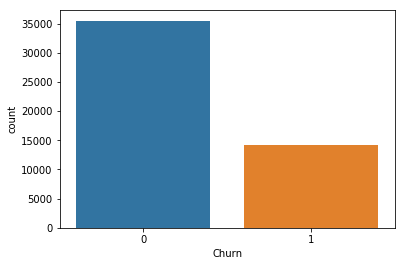

In [23]:
# Create countplot
sns.countplot(x='Churn',data=tele)

In [24]:
# Calculate churn percentage:
Churn_Pct = tele["Churn"][tele["Churn"] == 1]
print ("Churn Percentage = "+str( (Churn_Pct.shape[0] / tele["Churn"].shape[0]) * 100 ))

Churn Percentage = 28.632014793375145


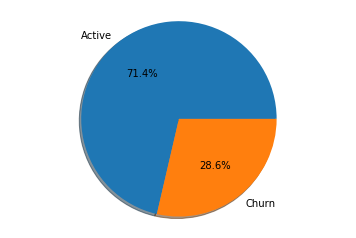

In [25]:
Churn=tele.Churn.sum()
Active=tele.Churn.count()-Churn
labels = ['Active', 'Churn']
sizes = [Active, Churn]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()

### Churn Percentage = 28.6%

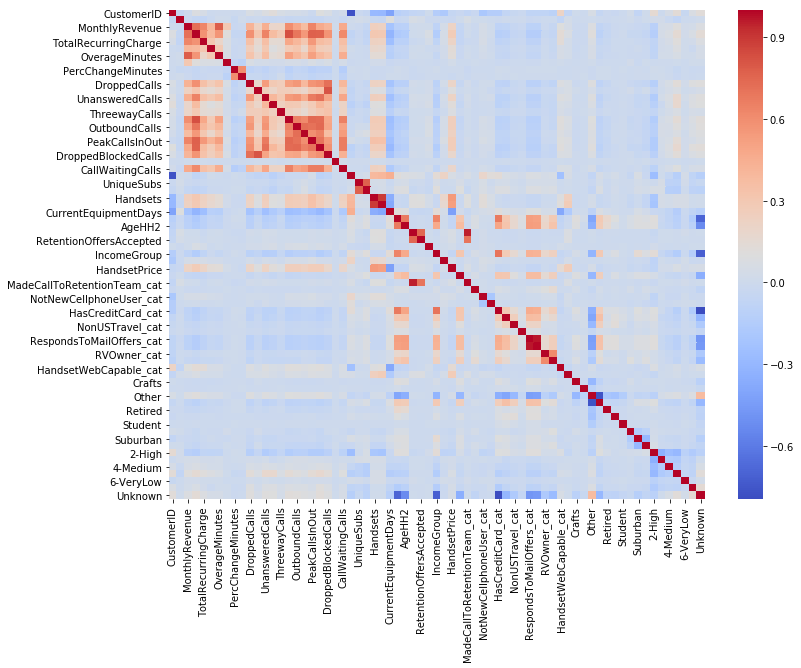

In [26]:
plt.figure(figsize=(12,9))
sns.heatmap(tele.corr(),cmap='coolwarm')

In [27]:
# Visualisation for top 10 features 
top_10_features =pd.DataFrame(tele[['MonthlyMinutes',
 'PercChangeMinutes',
 'MonthsInService',
 'TotalRecurringCharge',
 'CurrentEquipmentDays',
 'PercChangeRevenues',
 'OverageMinutes',
 'MonthlyRevenue',
 'UniqueSubs',
 'OffPeakCallsInOut','Churn']])
top_10_features.head()

,MonthlyMinutes,PercChangeMinutes,MonthsInService,TotalRecurringCharge,CurrentEquipmentDays,PercChangeRevenues,OverageMinutes,MonthlyRevenue,UniqueSubs,OffPeakCallsInOut,Churn
0,219.0,-157.0,61,22.0,361.0,-19.0,0.0,24.00,2,24.0,1
1,10.0,-4.0,58,17.0,1504.0,0.0,0.0,16.99,1,1.0,1
2,8.0,-2.0,60,38.0,1812.0,0.0,0.0,38.00,1,3.7,0
3,1312.0,157.0,59,75.0,458.0,8.1,0.0,82.28,2,303.7,0
4,0.0,0.0,53,17.0,852.0,-0.2,0.0,17.14,2,0.0,1


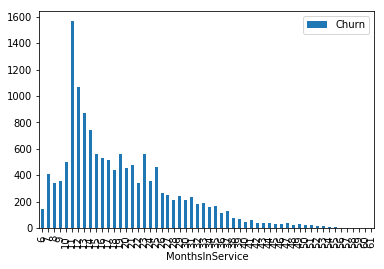

In [28]:
tele.groupby('MonthsInService')[['Churn']].sum().plot.bar()


We can see clearly that customers who are in MonthsInService 11 and 12 have highest churn rate

## Pairplot for top 10 features importance

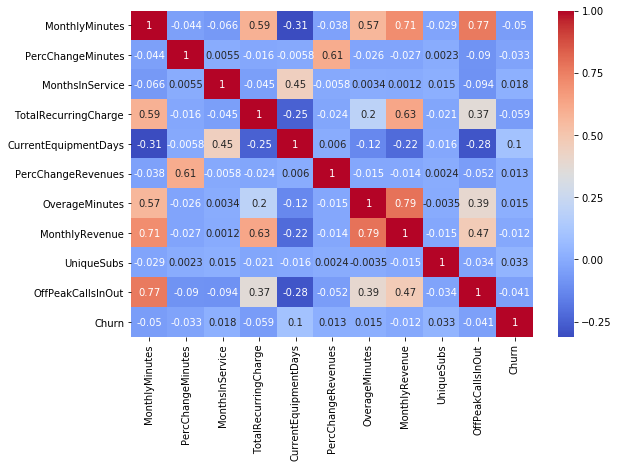

In [29]:
plt.figure(figsize=(9,6))
sns.heatmap(top_10_features.corr(),cmap='coolwarm', annot=True)

In [30]:
MonthlyMinutes = pd.DataFrame(tele.groupby(['MonthlyMinutes'])[['Churn']].sum())
MonthlyMinutes = MonthlyMinutes.sort_values(by=['Churn'], ascending = False)
MonthlyMinutes.head(5)

,Churn
MonthlyMinutes,
0.0,403
6.0,48
2.0,46
100.0,41
10.0,41


#### The lower MonthlyMinutes the higher is churn rate

In [31]:
MonthlyRevenue = pd.DataFrame(df.groupby('MonthlyRevenue')[['Churn']].sum())
MonthlyRevenue = MonthlyRevenue.sort_values(by=['Churn'], ascending = False)
MonthlyRevenue.head(20)

,Churn
MonthlyRevenue,
29.99,332
34.99,201
10.00,190
49.99,122
30.00,106
30.26,92
19.99,56
59.99,53
5.00,49


MonthlyRevenue is around £29.99, £34.99, £10, £49.99, £30, £39.99, £59.99, £19.99 these customers have higher churn rates. If we look closer, these could be the price of the products

In [32]:
CurrentEquipmentDays = pd.DataFrame(df.groupby('CurrentEquipmentDays')[['Churn']].sum())
CurrentEquipmentDays = CurrentEquipmentDays.sort_values(by=['Churn'], ascending = False)
CurrentEquipmentDays.head(10)

,Churn
CurrentEquipmentDays,
309.0,64
342.0,62
334.0,61
320.0,61
321.0,60
322.0,59
310.0,55
313.0,54
332.0,54


### if CurrentEquipmentDays is around 300 days, customer morelikely is becoming churn

In [33]:
TotalRecurringCharge = pd.DataFrame(tele.groupby('TotalRecurringCharge')[['Churn']].sum())
TotalRecurringCharge = TotalRecurringCharge.sort_values(by=['Churn'], ascending = False)
TotalRecurringCharge.head(20)

,Churn
TotalRecurringCharge,
30.0,2485
45.0,1656
40.0,1253
60.0,1252
50.0,1216
10.0,1037
70.0,543
32.0,336
85.0,300


## if TotalRecurringCharge is lower than 100, it has higher churn rate

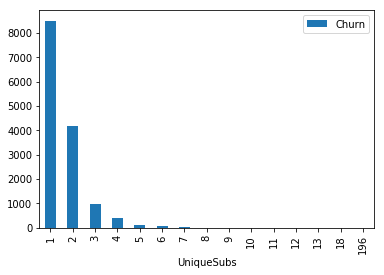

In [34]:
pd.DataFrame(df.groupby('UniqueSubs')[['Churn']].sum()).plot.bar()

### the lower UniqueSubs, the higher churn rate. Attention to UniqueSubs from 0-4

In [35]:
OffPeakCallsInOut = pd.DataFrame(tele.groupby('OffPeakCallsInOut')[['Churn']].sum())
OffPeakCallsInOut = OffPeakCallsInOut.sort_values(by=['Churn'], ascending = False)
OffPeakCallsInOut.head(20)

,Churn
OffPeakCallsInOut,
0.0,1533
0.7,103
0.3,97
1.3,94
1.0,91
3.0,89
4.0,88
3.7,88
1.7,86


## the lower the OffPeakCallsInOut the higher churn rate is.

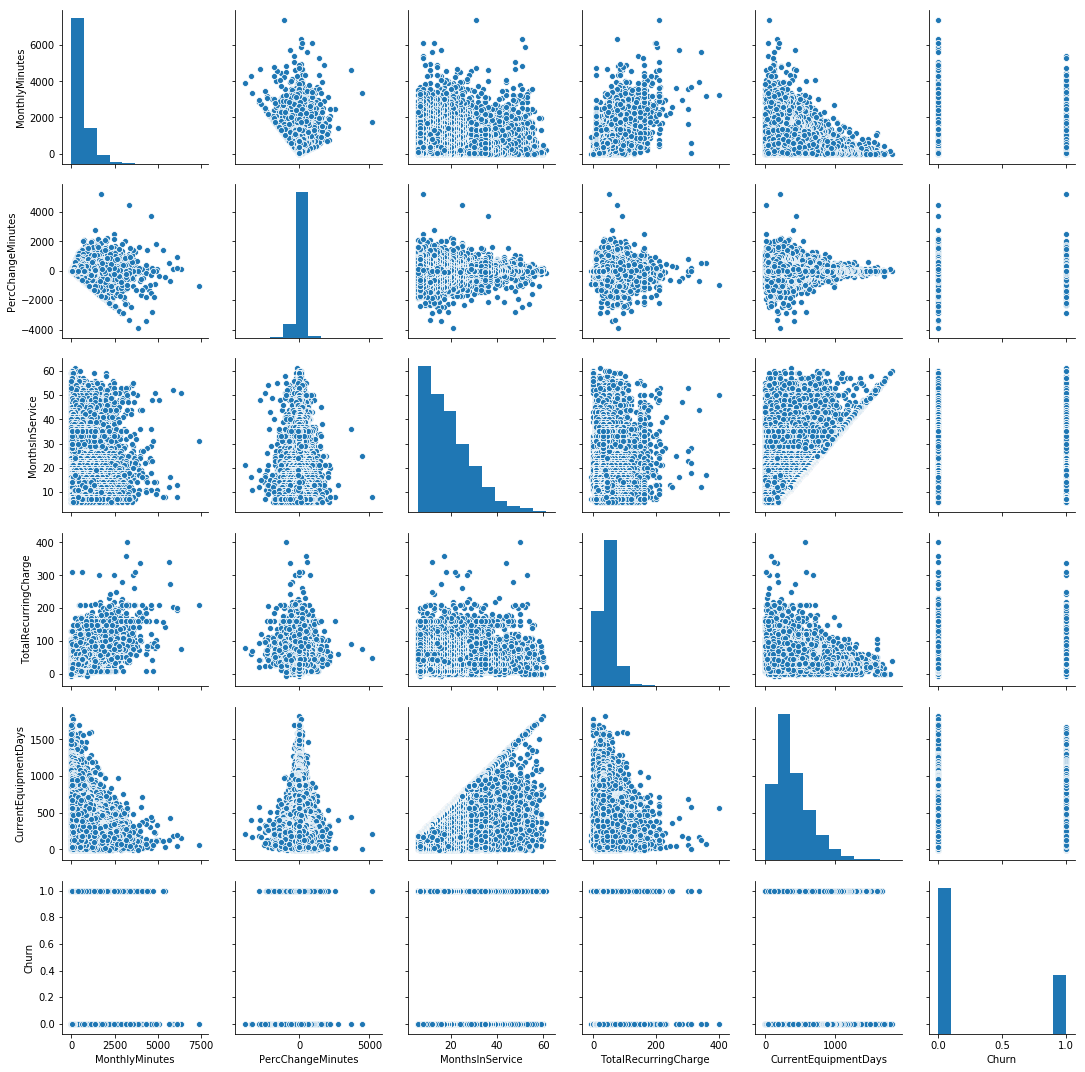

In [36]:
# Pairplot for top 5 features
sns.pairplot(df[['MonthlyMinutes',
                     'PercChangeMinutes',
                     'MonthsInService',
                     'TotalRecurringCharge',
                     'CurrentEquipmentDays',
                    'Churn']])

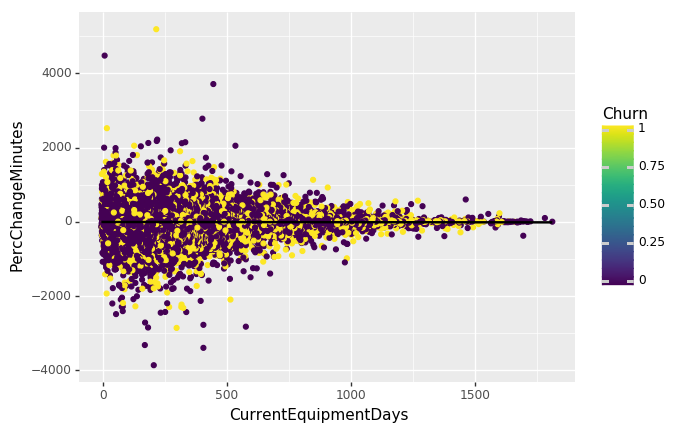

<ggplot: (-9223371892541252138)>

In [37]:
from plotnine import *
ggplot(mapping=aes(y='PercChangeMinutes', x='CurrentEquipmentDays', color = 'Churn'), data=df) +\
geom_point() +\
stat_smooth(method='lm')

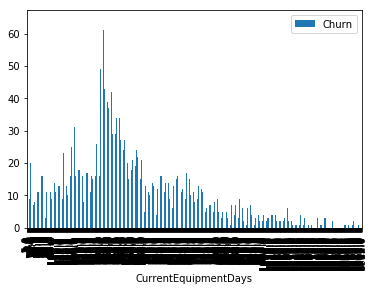

In [38]:
tele.groupby('CurrentEquipmentDays')[['Churn']].sum().plot.bar()

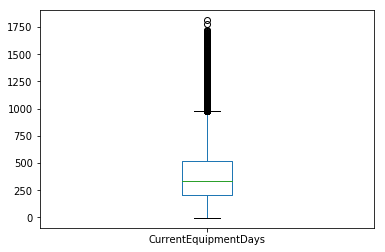

In [39]:
tele['CurrentEquipmentDays'].plot.box()

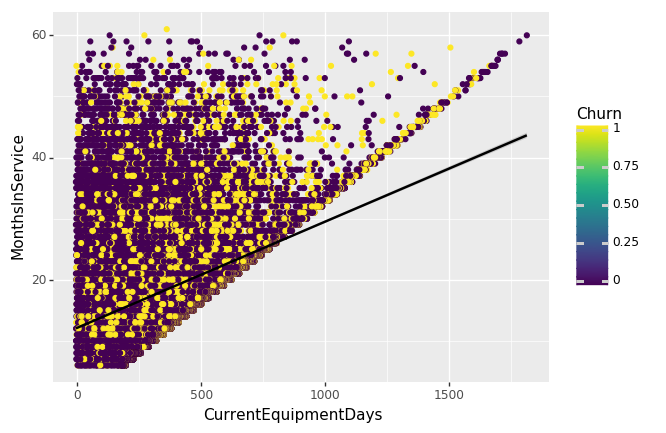

<ggplot: (-9223371892539577049)>

In [40]:
from plotnine import *

ggplot(mapping=aes(x='CurrentEquipmentDays', y='MonthsInService', color = 'Churn'), data=tele) +\
geom_point() +\
stat_smooth(method='lm')

# 2.Churn Prediction Models

From here we use clean dataset for modelling

In [41]:
df = pd.read_csv('CleanDataset.csv')

In [42]:
# Prepare data for modelling
X = df.drop(['Churn', 'CustomerID'], axis = 1)
y = df['Churn']

In [43]:
#Split train dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
cv = ms.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2.1 Logistic regression

In [44]:
Logistic_model = lm.LogisticRegression(C=1e50, solver='liblinear')
Logistic_model.fit(X_train, y_train)

LogisticRegression(C=1e+50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [45]:
Log_acs=metrics.accuracy_score(y_train, Logistic_model.predict(X_train))
Log_acs

0.7147579060210827

In [46]:
metrics.confusion_matrix(y_train, Logistic_model.predict(X_train))

array([[31620,   392],
       [12380,   384]], dtype=int64)

### Logistic model results:

In [47]:
# compute confusion matrix and classification report for log model
predictions = Logistic_model.predict(X_train)

print(confusion_matrix(y_train, predictions))
print ('\n')
print (classification_report(y_train, predictions))
print ('Accuracy:',Log_acs)

[[31620   392]
 [12380   384]]


              precision    recall  f1-score   support

           0       0.72      0.99      0.83     32012
           1       0.49      0.03      0.06     12764

   micro avg       0.71      0.71      0.71     44776
   macro avg       0.61      0.51      0.44     44776
weighted avg       0.65      0.71      0.61     44776

Accuracy: 0.7147579060210827


Cross validation - scale data and gridsearchvc

In [49]:
scaled_logreg = Pipeline([
    ('std', preprocessing.StandardScaler()),
    ('reg', lm.LogisticRegression(solver='liblinear'))
])

#Determine 'optimal' value of C by cross-validation using AUC scoring.
gs = ms.GridSearchCV(estimator=scaled_logreg,
                     param_grid={'reg__C': np.logspace(-5, 5, 11)},
                     scoring='roc_auc',
                     cv=cv)
gs.fit(X_train, y_train)

C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, f

C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 wer

C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were al

C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, f

C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 wer

C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, f

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'reg__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [50]:
gs.best_score_

0.6192449457881568

In [51]:
gs.best_estimator_.named_steps['reg']

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

# 2.2 Random Forest

In [52]:
# train the random forest with 10 decision trees, max_depth=10
RFC_model = RandomForestClassifier(n_estimators = 10, 
                                   max_depth=10, 
                                   random_state=42)

# fit the model
RFC_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### Cross validation - defied 5 stratifield K-folds

In [53]:
aucs = ms.cross_val_score(RFC_model, X_train, y_train, scoring='roc_auc', cv=cv)
np.mean(aucs)

0.6440150713943753

In [54]:
accuracy_score = ms.cross_val_score(RFC_model, X_train, y_train, scoring='accuracy', cv=cv)
np.mean(accuracy_score)

0.7181525648163152

In [55]:
Classifier_predict = RFC_model.predict(X_train)

### Random forest model result

In [56]:
print(confusion_matrix(y_train, Classifier_predict))
print ('\n')
print (classification_report(y_train, Classifier_predict))
print ('\n')
print('Accuracy: ',np.mean(accuracy_score))

[[31894   118]
 [11851   913]]


              precision    recall  f1-score   support

           0       0.73      1.00      0.84     32012
           1       0.89      0.07      0.13     12764

   micro avg       0.73      0.73      0.73     44776
   macro avg       0.81      0.53      0.49     44776
weighted avg       0.77      0.73      0.64     44776



Accuracy:  0.7181525648163152


In [57]:
# Increase the number of trees with max_depth =10
for n_trees in [15, 20, 50, 100,200,300,400]:
    estimator = ensemble.RandomForestClassifier(n_estimators=n_trees, 
                                                max_depth=10,
                                                random_state=42)
    aucs = ms.cross_val_score(estimator, X_train, y_train, scoring='roc_auc', cv=cv)  
    acs = ms.cross_val_score(estimator, X_train, y_train,  scoring='accuracy', cv=cv)
    print('{:>3} trees: mean AUC {:.2%}'.format(n_trees, np.mean(aucs))) 
    print('{:>3} trees: mean Accuracy {:.2%}'.format(n_trees, np.mean(acs)))      
    

 15 trees: mean AUC 65.12%
 15 trees: mean Accuracy 71.86%
 20 trees: mean AUC 65.34%
 20 trees: mean Accuracy 71.81%
 50 trees: mean AUC 66.05%
 50 trees: mean Accuracy 71.89%
100 trees: mean AUC 66.31%
100 trees: mean Accuracy 71.86%
200 trees: mean AUC 66.49%
200 trees: mean Accuracy 71.87%
300 trees: mean AUC 66.54%
300 trees: mean Accuracy 71.88%
400 trees: mean AUC 66.57%
400 trees: mean Accuracy 71.89%


The result doesn't improve much from logistic regression. We'll try to train the model using gradient tree boosting

# 2.3 Gradient tree boosting

In [58]:
pipeline = Pipeline([
    ('std', StandardScaler()), 
    ('GBC', ensemble.GradientBoostingClassifier())
])
pipeline.steps

[('std', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('GBC', GradientBoostingClassifier(criterion='friedman_mse', init=None,
                learning_rate=0.1, loss='deviance', max_depth=3,
                max_features=None, max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=100,
                n_iter_no_change=None, presort='auto', random_state=None,
                subsample=1.0, tol=0.0001, validation_fraction=0.1,
                verbose=0, warm_start=False))]

In [59]:
# train model with 10 n_estimators, max_depth=10
gbt1 = ensemble.GradientBoostingClassifier(
                                           n_estimators=10, 
                                           max_depth=10,
                                           random_state=42)
gbt1.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [63]:
# Cross validation with pipeline
aucs = ms.cross_val_score(pipeline , X_train, y_train, scoring='roc_auc', cv=cv)

acc = ms.cross_val_score(pipeline , X_train, y_train, scoring='accuracy', cv=cv)

print('AUCS: ',np.mean(aucs))
print('ACCURACY: ',np.mean(acc))

C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, floa

AUCS:  0.6710100307690414
ACCURACY:  0.7218821751134559


C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [65]:
# increase number of trees
for n_trees in [50,100,200,300, 400]:
    estimator = ensemble.GradientBoostingClassifier(n_estimators=n_trees,
                                                    max_depth=5,
                                                    random_state=42)
    
    aucs = ms.cross_val_score(estimator, X_train, y_train,  scoring='roc_auc', cv=cv)
    acs = ms.cross_val_score(estimator, X_train, y_train,  scoring='accuracy', cv=cv)
    
    print('{:>3} trees: mean AUC {:.2%}'.format(n_trees, np.mean(aucs)))    
    print('{:>3} trees: mean Accuracy {:.2%}'.format(n_trees, np.mean(acs)))

 50 trees: mean AUC 67.06%
 50 trees: mean Accuracy 72.29%
100 trees: mean AUC 67.43%
100 trees: mean Accuracy 72.38%
200 trees: mean AUC 67.36%
200 trees: mean Accuracy 72.33%
300 trees: mean AUC 67.20%
300 trees: mean Accuracy 72.26%


KeyboardInterrupt: 

100 n_trees with max_depth 5 is the best

In [76]:
hyperparameters = {'max_depth':[5,10,15],
                   'n_estimators':[50,100,150]}
                #'learning_rate':list(np.arange(0.01,1.0,0.01))}

model_to_tune = ensemble.GradientBoostingClassifier(learning_rate=0.01,
                                                    n_estimators=5, 
                                                    max_depth = 2,
                                                    min_samples_split=2, 
                                                    min_samples_leaf=1, 
                                                    subsample=1,
                                                    max_features='sqrt', 
                                                    random_state=42)

model_gscv = ms.GridSearchCV(estimator = model_to_tune, 
            param_grid = hyperparameters, 
            scoring='accuracy',
            n_jobs=4,
            iid=False, 
            cv=5,
            verbose=3)

#Run GSCV on model_to_tune
model_gscv.fit(X_train,y_train)

#Get best parameters
model_gscv.cv_results_, model_gscv.best_params_, model_gscv.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed: 22.6min finished
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which w

({'mean_fit_time': array([  4.9872333 ,   9.50343909,  13.8863204 ,  31.49150944,
          62.78086104,  89.48917956, 142.37574539, 311.73728714,
         339.70006361]),
  'std_fit_time': array([4.49282989e-02, 7.76056493e-02, 1.92921042e-01, 4.70290307e-01,
         5.28424083e-01, 2.67396703e+00, 5.19271600e+00, 9.36348344e+00,
         9.64663813e+01]),
  'mean_score_time': array([0.06068187, 0.09822493, 0.13332262, 0.1203403 , 0.20530529,
         0.26619897, 0.14974217, 0.31035218, 0.23098917]),
  'std_score_time': array([0.00444627, 0.00722762, 0.00326314, 0.00325096, 0.00580276,
         0.02478886, 0.0346088 , 0.05354222, 0.03732313]),
  'param_max_depth': masked_array(data=[5, 5, 5, 10, 10, 10, 15, 15, 15],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_n_estimators': masked_array(data=[50, 100, 150, 50, 100, 150, 50, 100, 150],
               mask=[False

# Feature importance

In [77]:
#Top 10 features
all_features = pd.DataFrame(sorted(zip(model_gscv.best_estimator_.feature_importances_,X_train.columns), reverse = True),columns=['Ranking','Feature'])
top_10_features = list(all_features['Feature'][0:10])
top_10_features

['CurrentEquipmentDays',
 'PercChangeMinutes',
 'MonthlyMinutes',
 'MonthsInService',
 'PercChangeRevenues',
 'MonthlyRevenue',
 'PeakCallsInOut',
 'OffPeakCallsInOut',
 'ReceivedCalls',
 'UnansweredCalls']

Re-train the model for top 10 features

In [104]:
# Prepare data for modelling
X = df[top_10_features]
y = df['Churn']

#Split train dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

#Cross validation
cv = ms.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [105]:
gbt2 = ensemble.GradientBoostingClassifier(
                                           n_estimators=100, 
                                           max_depth=5,
                                           random_state=42)
gbt2.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [106]:
aucs = ms.cross_val_score(gbt2 , X_train, y_train, scoring='roc_auc', cv=cv)
acc = ms.cross_val_score(gbt2 , X_train, y_train, scoring='accuracy', cv=cv)
print('AUCS: ',np.mean(aucs))
print('ACCURACY: ',np.mean(acc))

AUCS:  0.662981950808797
ACCURACY:  0.7217036835378513


In [107]:
for n_trees in [50,100,200,300,400]:
    estimator = ensemble.GradientBoostingClassifier(n_estimators=n_trees,
                                                    max_depth=5,
                                                    random_state=42)    
    aucs = ms.cross_val_score(estimator, X_train, y_train,  scoring='roc_auc', cv=cv)
    acs = ms.cross_val_score(estimator, X_train, y_train,  scoring='accuracy', cv=cv)    
    print('{:>3} trees: mean AUC {:.2%}'.format(n_trees, np.mean(aucs)))    
    print('{:>3} trees: mean Accuracy {:.2%}'.format(n_trees, np.mean(acs)))

 50 trees: mean AUC 66.12%
 50 trees: mean Accuracy 72.17%
100 trees: mean AUC 66.30%
100 trees: mean Accuracy 72.17%
200 trees: mean AUC 66.19%
200 trees: mean Accuracy 72.05%
300 trees: mean AUC 65.92%
300 trees: mean Accuracy 71.88%
400 trees: mean AUC 65.68%
400 trees: mean Accuracy 71.82%


The result gives us the best number of trees is 100 with max_depth=5

# 2.4 Light GBM

In [66]:
import lightgbm as lgb

In [67]:
tuning_params = {
    'max_depth': [5,10,15,20],
    'num_leaves': [5,10,15,20],
    'n_estimators':[10,20,50,100,200,300,400]
    }

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'verbose': 100,
            'categorical_feature': 'auto'}

clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=100)

tuning = GridSearchCV(estimator=clf, 
                                param_grid=tuning_params,
                                cv=cv,
                                refit=True,
                                verbose=True)

tuning.fit(X_train, y_train, **fit_params)

print('Best score reached: {} with params: {} '.format(tuning.best_score_, tuning.best_params_))

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.636434
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.636018
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.638445
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.637989
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.632913
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.64804
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.649289
Training until validation sco

Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.677951
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.670412
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.670412
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.671699
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.671699
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.671892
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.671892
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.66825
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.66825
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.669339
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.669444
Training until

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.676294
[200]	valid_0's auc: 0.678674
Early stopping, best iteration is:
[170]	valid_0's auc: 0.679209
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.681307
[200]	valid_0's auc: 0.683943
Early stopping, best iteration is:
[220]	valid_0's auc: 0.684886
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.680932
[200]	valid_0's auc: 0.68586
Early stopping, best iteration is:
[205]	valid_0's auc: 0.686134
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.675681
Early stopping, best iteration is:
[97]	valid_0's auc: 0.676206
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.680626
Early stopping, best iteration is:
[136]	valid_0's auc: 0.682543
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.679463
Early stopping, best iteration is:


Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.652187
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.662192
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.658312
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.659298
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.657804
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.644505
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.649414
Training until validation sc

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.683236
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.683338
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.681366
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.682463
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.683192
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.68351
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.680703
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.680982
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.683069
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.683571
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.686887
Did not meet early stopping. Best iteration is:
[100]	valid_0's 

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.680649
Early stopping, best iteration is:
[119]	valid_0's auc: 0.682066
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.6821
Early stopping, best iteration is:
[105]	valid_0's auc: 0.682678
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.670412
[200]	valid_0's auc: 0.676608
[300]	valid_0's auc: 0.67985
Early stopping, best iteration is:
[290]	valid_0's auc: 0.680559
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.671699
[200]	valid_0's auc: 0.680114
[300]	valid_0's auc: 0.683897
Early stopping, best iteration is:
[331]	valid_0's auc: 0.685078
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.671892
[200]	valid_0's auc: 0.677027
[300]	valid_0's auc: 0.679814
Early stopping, best iteration is:
[293]	valid_0's auc: 0.680117
Training until validation scores don't

[20]	valid_0's auc: 0.66489
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.66726
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.667131
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.664352
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.667561
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.665556
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.67094
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.669946
T

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.669339
[200]	valid_0's auc: 0.67766
Did not meet early stopping. Best iteration is:
[193]	valid_0's auc: 0.677759
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.678095
[200]	valid_0's auc: 0.681243
Did not meet early stopping. Best iteration is:
[195]	valid_0's auc: 0.681603
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.680558
Early stopping, best iteration is:
[156]	valid_0's auc: 0.684646
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.67996
[200]	valid_0's auc: 0.68301
Did not meet early stopping. Best iteration is:
[186]	valid_0's auc: 0.68347
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.67423
Early stopping, best iteration is:
[82]	valid_0's auc: 0.674963
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.680886


Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.67423
Early stopping, best iteration is:
[82]	valid_0's auc: 0.674963
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.680886
[200]	valid_0's auc: 0.683016
Early stopping, best iteration is:
[215]	valid_0's auc: 0.684096
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.681052
[200]	valid_0's auc: 0.683726
Early stopping, best iteration is:
[202]	valid_0's auc: 0.683766
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.683516
[200]	valid_0's auc: 0.685611
Early stopping, best iteration is:
[242]	valid_0's auc: 0.68705
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.682518
[200]	valid_0's auc: 0.686136
Early stopping, best iteration is:
[231]	valid_0's auc: 0.687279
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.682144
Early 

Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.673802
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.674194
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.673723
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.671444
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.672237
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.67554
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[49]	valid_0's auc: 0.680781
Training until validation sc

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.680075
Early stopping, best iteration is:
[156]	valid_0's auc: 0.682508
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.685323
Early stopping, best iteration is:
[99]	valid_0's auc: 0.685634
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.68805
Early stopping, best iteration is:
[100]	valid_0's auc: 0.68805
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.680232
Early stopping, best iteration is:
[70]	valid_0's auc: 0.682121
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.683293
Early stopping, best iteration is:
[107]	valid_0's auc: 0.684356
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.670412
[200]	valid_0's auc: 0.676608
[300]	valid_0's auc: 0.67985
Did not meet early stopping. Best iteration is:
[290]	valid_0's auc:

[Parallel(n_jobs=1)]: Done 560 out of 560 | elapsed: 10.3min finished


Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.671934
[200]	valid_0's auc: 0.67989
Early stopping, best iteration is:
[265]	valid_0's auc: 0.682938
Best score reached: 0.7248749329998213 with params: {'max_depth': 5, 'n_estimators': 400, 'num_leaves': 5} 


In [86]:
print('Best score reached: {} with params: {} '.format(tuning.best_score_, tuning.best_params_))

Best score reached: 0.7248749329998213 with params: {'max_depth': 5, 'n_estimators': 400, 'num_leaves': 5} 


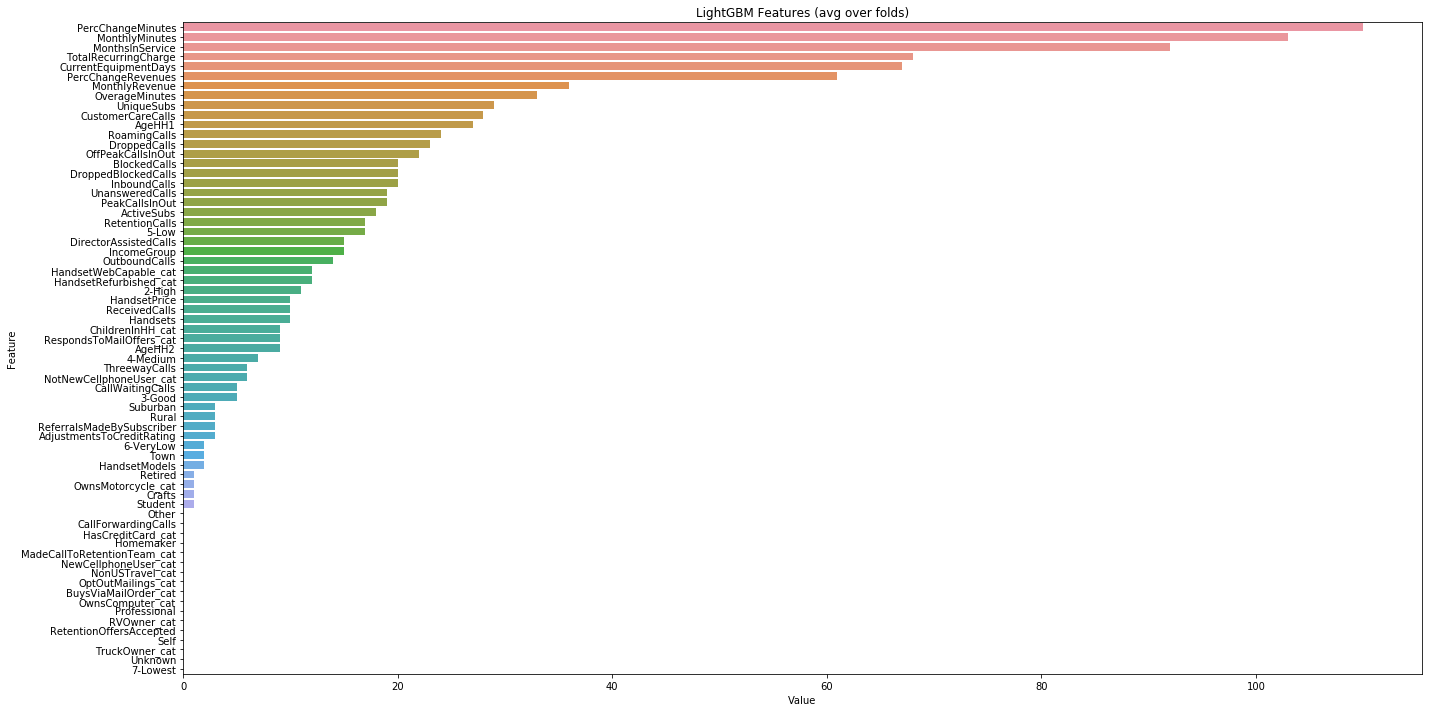

In [87]:
#Feature importance
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(tuning.best_estimator_.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

# 3. Final model

### Use top 10 features to fit the model again

In [90]:
#Top 10 features
all_features = pd.DataFrame(sorted(zip(tuning.best_estimator_.feature_importances_,X_train.columns), reverse = True),columns=['Ranking','Feature'])
top_10_features = list(all_features['Feature'][0:10])
top_10_features

['MonthlyRevenue',
 'MonthlyMinutes',
 'MonthsInService',
 'OverageMinutes',
 'PercChangeMinutes',
 'CurrentEquipmentDays',
 'PercChangeRevenues',
 'UniqueSubs',
 'CustomerCareCalls',
 'TotalRecurringCharge']

In [91]:
# Prepare data for modelling
X = df[top_10_features]
y = df['Churn']

#Split train dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

cv = ms.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [92]:
tuning_params = {
    'max_depth': [5,10,15,20,25,30],
    'num_leaves': [5,10,15,20,25,30,50,100],
    'n_estimators':[10,20,50,100,200,300,400]
    }

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'verbose': 100,
            'categorical_feature': 'auto'}

clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)

tuning = GridSearchCV(estimator=clf, 
                                param_grid=tuning_params,
                                cv=cv,
                                refit=True,
                                verbose=True)

tuning.fit(X_train, y_train, **fit_params)

print('Best score reached: {} with params: {} '.format(tuning.best_score_, tuning.best_params_))

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[2]	valid_0's auc: 0.612105


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.611398
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.61386
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.608008
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.617701
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.630955
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.626897
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.63114
Training until validation scor

Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.643555
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.6422
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.641343
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.638627
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.645307
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.643226
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.640055
Training until validation sco

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.648015
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.648135
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.647876
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.647876
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.646945
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.646945
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.645139
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.645139
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.646823
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.646823
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.654141
Did not meet early stopping. Best iteration is:
[95]	valid_

[100]	valid_0's auc: 0.649489
Early stopping, best iteration is:
[155]	valid_0's auc: 0.654003
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.649737
Early stopping, best iteration is:
[157]	valid_0's auc: 0.652485
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.654773
Early stopping, best iteration is:
[133]	valid_0's auc: 0.656417
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.653602
Early stopping, best iteration is:
[90]	valid_0's auc: 0.654014
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.651335
Early stopping, best iteration is:
[107]	valid_0's auc: 0.651979
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.653603
Early stopping, best iteration is:
[148]	valid_0's auc: 0.656267
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.652959
Early stopping, best iteratio

[100]	valid_0's auc: 0.652795
Early stopping, best iteration is:
[147]	valid_0's auc: 0.654774
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.655523
Early stopping, best iteration is:
[123]	valid_0's auc: 0.656854
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.6564
Early stopping, best iteration is:
[90]	valid_0's auc: 0.657301
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[58]	valid_0's auc: 0.652367
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.655024
Early stopping, best iteration is:
[150]	valid_0's auc: 0.656372
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.650405
Early stopping, best iteration is:
[138]	valid_0's auc: 0.652101
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.654446
Early stopping, best iteration is:
[72]	valid_0's auc: 0.65572

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.656696
Early stopping, best iteration is:
[132]	valid_0's auc: 0.658514
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.650609
Early stopping, best iteration is:
[126]	valid_0's auc: 0.651788
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.65252
Early stopping, best iteration is:
[136]	valid_0's auc: 0.654823
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.652215
Early stopping, best iteration is:
[103]	valid_0's auc: 0.652396
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[56]	valid_0's auc: 0.654969
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.656696
Early stopping, best iteration is:
[132]	valid_0's auc: 0.658514
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.65060

Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.640979
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.638244
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.638207
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.636815
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.639056
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.644749
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.643352
Training until validation s

Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.655536
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.656037
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[48]	valid_0's auc: 0.655747
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[49]	valid_0's auc: 0.650393
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.653996
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.653324
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[37]	valid_0's auc: 0.655094
Training until validation s

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.645139
[200]	valid_0's auc: 0.65158
Did not meet early stopping. Best iteration is:
[185]	valid_0's auc: 0.651816
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.646823
[200]	valid_0's auc: 0.653523
Did not meet early stopping. Best iteration is:
[198]	valid_0's auc: 0.653803
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.654609
Early stopping, best iteration is:
[89]	valid_0's auc: 0.655082
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.654874
[200]	valid_0's auc: 0.657781
Did not meet early stopping. Best iteration is:
[182]	valid_0's auc: 0.658692
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.649733
Early stopping, best iteration is:
[164]	valid_0's auc: 0.651446
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.650

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.653904
Early stopping, best iteration is:
[79]	valid_0's auc: 0.655636
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.655058
Early stopping, best iteration is:
[81]	valid_0's auc: 0.656193
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[53]	valid_0's auc: 0.650829
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.65314
Early stopping, best iteration is:
[126]	valid_0's auc: 0.655058
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[41]	valid_0's auc: 0.652063
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[46]	valid_0's auc: 0.656815
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.656942
Early stopping, best iteration is:
[80]	valid_0's auc: 0.65859

Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[39]	valid_0's auc: 0.656037
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[48]	valid_0's auc: 0.655747
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[66]	valid_0's auc: 0.650849
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[67]	valid_0's auc: 0.655652
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.652503
Early stopping, best iteration is:
[76]	valid_0's auc: 0.653671
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.652381
Early stopping, best iteration is:
[75]	valid_0's auc: 0.65589
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[52]	valid_0's auc: 0.651439
Training until validation scores don't improve for 30 round

Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.640979
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.638244
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.638207
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.636815
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.639056
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.644749
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.643352
Training until validation s

Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[49]	valid_0's auc: 0.65424
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.657477
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.654812
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[39]	valid_0's auc: 0.654063
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.654653
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.652901
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.653872
Training until validation sc

[100]	valid_0's auc: 0.645139
[200]	valid_0's auc: 0.65158
Did not meet early stopping. Best iteration is:
[185]	valid_0's auc: 0.651816
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.646823
[200]	valid_0's auc: 0.653523
Did not meet early stopping. Best iteration is:
[198]	valid_0's auc: 0.653803
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.654609
Early stopping, best iteration is:
[89]	valid_0's auc: 0.655082
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.654874
[200]	valid_0's auc: 0.657781
Did not meet early stopping. Best iteration is:
[182]	valid_0's auc: 0.658692
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.649733
Early stopping, best iteration is:
[164]	valid_0's auc: 0.651446
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.650701
[200]	valid_0's auc: 0.653379
Did not meet early stopping.

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.656136
Early stopping, best iteration is:
[92]	valid_0's auc: 0.656545
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[52]	valid_0's auc: 0.650925
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[53]	valid_0's auc: 0.652461
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.654284
Early stopping, best iteration is:
[131]	valid_0's auc: 0.655397
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[62]	valid_0's auc: 0.657195
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.655331
Early stopping, best iteration is:
[82]	valid_0's auc: 0.655916
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[54]	valid_0's auc: 0.651114
Training until validation s

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.6507
Early stopping, best iteration is:
[71]	valid_0's auc: 0.654641
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[58]	valid_0's auc: 0.654672
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[61]	valid_0's auc: 0.653896
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[34]	valid_0's auc: 0.653872
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[33]	valid_0's auc: 0.651437
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[37]	valid_0's auc: 0.652022
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[50]	valid_0's auc: 0.654902
Training until validation scores don't improve for 30 rounds.
Early stopping, best iterati

Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.638207
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.636815
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.639056
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.644749
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.643352
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.643905
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.640725
Training until validation s

Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[47]	valid_0's auc: 0.655136
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.653999
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.655849
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[49]	valid_0's auc: 0.654477
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[42]	valid_0's auc: 0.650903
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.651109
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[36]	valid_0's auc: 0.651387
Training until validation s

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.654609
Early stopping, best iteration is:
[89]	valid_0's auc: 0.655082
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.654874
[200]	valid_0's auc: 0.657781
Did not meet early stopping. Best iteration is:
[182]	valid_0's auc: 0.658692
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.649733
Early stopping, best iteration is:
[164]	valid_0's auc: 0.651446
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.650701
[200]	valid_0's auc: 0.653379
Did not meet early stopping. Best iteration is:
[182]	valid_0's auc: 0.654
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.64987
[200]	valid_0's auc: 0.653859
Did not meet early stopping. Best iteration is:
[189]	valid_0's auc: 0.654385
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.655737

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.654284
Early stopping, best iteration is:
[131]	valid_0's auc: 0.655397
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[62]	valid_0's auc: 0.657195
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.655331
Early stopping, best iteration is:
[82]	valid_0's auc: 0.655916
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[54]	valid_0's auc: 0.651114
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[52]	valid_0's auc: 0.652259
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.656147
Early stopping, best iteration is:
[88]	valid_0's auc: 0.657889
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[45]	valid_0's auc: 0.658046
Training until validation s

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.649748
Early stopping, best iteration is:
[80]	valid_0's auc: 0.652365
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[36]	valid_0's auc: 0.651387
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[32]	valid_0's auc: 0.652171
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[43]	valid_0's auc: 0.653548
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[2]	valid_0's auc: 0.612105
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.611398
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.61386
Training until validation scores don't improve for 

Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.643352
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.643905
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.640725
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.642568
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.649541
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.645467
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.643503
Training until validation s

Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[29]	valid_0's auc: 0.649717
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[48]	valid_0's auc: 0.650666
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.653435
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[43]	valid_0's auc: 0.652508
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[33]	valid_0's auc: 0.652217
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.648015
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.648135
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.647876
Did not meet early stopping. Best iteration 

[100]	valid_0's auc: 0.650701
[200]	valid_0's auc: 0.653379
Did not meet early stopping. Best iteration is:
[182]	valid_0's auc: 0.654
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.64987
[200]	valid_0's auc: 0.653859
Did not meet early stopping. Best iteration is:
[189]	valid_0's auc: 0.654385
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.655737
Early stopping, best iteration is:
[128]	valid_0's auc: 0.656984
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.654653
Early stopping, best iteration is:
[162]	valid_0's auc: 0.655709
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.64932
Early stopping, best iteration is:
[85]	valid_0's auc: 0.650416
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.650279
Early stopping, best iteration is:
[114]	valid_0's auc: 0.651604
Training until validation scores don't i

Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[52]	valid_0's auc: 0.652259
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.656147
Early stopping, best iteration is:
[88]	valid_0's auc: 0.657889
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[45]	valid_0's auc: 0.658046
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[68]	valid_0's auc: 0.65834
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[44]	valid_0's auc: 0.653624
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[49]	valid_0's auc: 0.65331
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[49]	valid_0's auc: 0.65424
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteratio

[10]	valid_0's auc: 0.611398
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.61386
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.608008
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.617701
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[8]	valid_0's auc: 0.630955
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.627089
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.630366
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.628092
T

Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.645467
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.643503
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.643428
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.644286
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.64912
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.647952
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.644909
Training until validation sc

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.648015
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.648135
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.647876
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.647876
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.646945
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.646945
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.645139
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.645139
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.646823
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.646823
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.654609
Did not meet early stopping. Best iteration is:
[89]	valid_

[100]	valid_0's auc: 0.64932
Early stopping, best iteration is:
[85]	valid_0's auc: 0.650416
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.650279
Early stopping, best iteration is:
[114]	valid_0's auc: 0.651604
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.653752
Early stopping, best iteration is:
[169]	valid_0's auc: 0.655111
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.657426
Early stopping, best iteration is:
[89]	valid_0's auc: 0.657868
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.656136
Early stopping, best iteration is:
[92]	valid_0's auc: 0.656545
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[52]	valid_0's auc: 0.650925
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[53]	valid_0's auc: 0.652461
Training until validation sco

Early stopping, best iteration is:
[49]	valid_0's auc: 0.65331
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[49]	valid_0's auc: 0.65424
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[35]	valid_0's auc: 0.655743
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[54]	valid_0's auc: 0.656018
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[42]	valid_0's auc: 0.653999
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[50]	valid_0's auc: 0.655849
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.651445
Early stopping, best iteration is:
[70]	valid_0's auc: 0.65625
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[29]	valid_0's auc: 0.649717
Training until validation s

[Parallel(n_jobs=1)]: Done 1680 out of 1680 | elapsed: 14.6min finished


Training until validation scores don't improve for 30 rounds.
[100]	valid_0's auc: 0.656283
Early stopping, best iteration is:
[114]	valid_0's auc: 0.657221
Best score reached: 0.723311595497588 with params: {'max_depth': 10, 'n_estimators': 200, 'num_leaves': 15} 


- Best score reached: 0.723311595497588 with params: {'max_depth': 10, 'n_estimators': 200, 'num_leaves': 15} 
- Accuracy descreased when using top 10 features

In [93]:
print('Best score reached: {} with params: {} '.format(tuning.best_score_, tuning.best_params_))

Best score reached: 0.723311595497588 with params: {'max_depth': 10, 'n_estimators': 200, 'num_leaves': 15} 


# Summary